In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import cv2
import random as rn
from tqdm import tqdm
import shutil 
from PIL import Image
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def Dataset_loader(DIR,RESIZE,Max_Size):
    IMG = []
    c = 0
    read = lambda imname: np.array(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
      PATH = os.path.join(DIR,IMAGE_NAME)
      _, ftype = os.path.splitext(PATH)
      if ftype == ".jpeg":
        img = read(PATH)
        img = np.array(cv2.resize(img, (RESIZE,RESIZE)))
        Xmin = np.min(img)
        Xmax = np.max(img)
        img -= Xmin
        img = img/(Xmax-Xmin)
        img *= 255 
        c += 1
        img = rgb2gray(img)
        IMG.append(img)
      if c == Max_Size:
        break
    return IMG

In [ ]:
Images = np.array(Dataset_loader('/content/drive/MyDrive/test_images',224,3))


 89%|████████▉ | 16/18 [00:00<00:00, 165.67it/s]


In [ ]:
def range_xy(sill, X, Y):
  percent95 = 0.95*sill
  for i in range(len(X)):
    if(Y[i] >= percent95):
      return X[i]
  return X[-1]

def spherical_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z[(Z.index<=a)]=nugget+(sill-nugget)*(1.5*Z/a-0.5*np.power(Z/a,3))
  Z[(Z.index>a)]=sill
  return np.array(Z)
    
def exponential_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*Z/a))
  return np.array(Z)
  
  
def gaussian_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*np.square(Z)/np.square(a)))
  return np.array(Z)

def mean_absolute_percentage_error(data, gold_grade='gold_grade', estimate='estimate'):
  error_series = (data.apply(lambda row: np.abs((row.gold_grade - row.estimate)/row.gold_grade), axis=1))
  return error_series.sum()*100/len(error_series)

from collections import defaultdict
def variogram(data, X = "X", Y = "Y", G="gold_grade", min_angle=0, angle_tolerance=90, no_of_lags = 10, lag_spacing=10, lag_tolerance=5):
    g_values = pd.DataFrame({'distance':[] , 'values':[]})
    x_y_values = defaultdict(lambda:0)
    count = defaultdict(lambda:0)
    for i in range(data.shape[0]):
        if(angle_tolerance >= 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle+angle_tolerance > 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance-180) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < min_angle-angle_tolerance))) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle-angle_tolerance < -90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < 180+min_angle-angle_tolerance))) &(np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        else:
            var_data = pd.DataFrame(np.array(data[(data.index > i) & ((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi >= min_angle-angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi <= min_angle+angle_tolerance)) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        var_data[X] -= data[X][i]
        var_data[Y] -= data[Y][i]
        var_data["distance"] = np.linalg.norm(var_data[[X, Y]], axis=1)
        var_data = var_data.drop(columns=[X, Y])
        var_data["values"] = var_data["values"] - data[G][i]
        g_values = g_values.append(var_data, ignore_index = True, sort=False)
        if(i%100 == 0):
            for j in range(0, no_of_lags*lag_spacing+1, lag_spacing):
                range_array = np.array(g_values[(g_values['distance']>j-lag_tolerance) & (g_values['distance'] <= j+lag_tolerance)]['values'])
                x_y_values[j] += np.sum(np.square(range_array), axis = 0)
                count[j] += range_array.shape[0]
            g_values = pd.DataFrame({'distance':[] , 'values':[]}) 
    x = []
    y = []
    for keys in x_y_values:
        x.append(keys)
        y.append(x_y_values[keys]/(2*count[keys]))
    return(x, y)

3

In [ ]:
# [X, Y] = variogram(test_data, no_of_lags=10, G='var', lag_spacing = 25, lag_tolerance = 15)
# plt.scatter(X, Y)
# plt.plot(spherical_model(test_data, X, Y,label='var'), 'g-')
# plt.plot(exponential_model(test_data, X, Y,label='var'), 'b-')
# plt.plot(gaussian_model(test_data, X, Y, label='var'), 'r-')
# plt.xlabel("Distance")
# plt.ylabel("Variogram")
# plt.title("Variogram")

In [ ]:
def covariance_function(nugget, sill, distance, a, model = "spherical"):
  if(model == "spherical"):
    return ((sill-nugget)*(1-1.5*distance/a+0.5*np.power(distance/a,3)))
  elif(model == "gaussian"):
    return ((sill-nugget)*(np.exp(-3*np.square(distance)/np.square(a))))
  elif(model == "exponential"):
    return ((sill-nugget)*(np.exp(-3*distance/a)))
  
count = 0
    
def find_estimate(data, x, y, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", max_points=4, kriging_type="ordinary"):
  points = pd.DataFrame({X:[], Y:[], G:[] , 'distance':[]})
  df1 = pd.DataFrame(np.array(data[(data[X] >= x) & (data[Y] >= y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] > x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] > y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  distances = pd.merge(pd.DataFrame({'key':1, 'X1':points[X], 'Y1':points[Y]}), pd.DataFrame({'key':1, 'X2':points[X], 'Y2':points[Y]}))
  distances['distance'] = np.sqrt(np.square(distances['X1']-distances['X2'])+np.square(distances['Y1']-distances['Y2']))
  dist_length = len(distances)
  if(kriging_type == "ordinary"):
    self_cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), np.array(points['distance']),  a, model), (0,1), 'constant', constant_values=(0, 1))
  elif(kriging_type == "block"):
    block_points = (pd.merge(pd.DataFrame({"key":1, "X":np.array(range(int(x)-50,int(x)+50))}), pd.DataFrame({"key":1, "Y":np.array(range(int(y)-50,int(y)+50))}), on='key'))
    b_shape = block_points.shape[0]
    p_shape = points.shape[0]
    block_points = (pd.merge(pd.DataFrame({"key":1, "X1":block_points[X], "Y1":block_points[Y]}), pd.DataFrame({"key":1, "X2":points[X], "Y2":points[Y]}), on='key'))
    block_points["distance"] = block_points.apply(lambda row: np.sqrt(np.square(row.X1-row.X2)+np.square(row.Y1-row.Y2)), axis = 1)
    self_cov_matrix = np.pad(np.average(covariance_function(nugget, (data[G]).var(), np.array(block_points["distance"]).reshape(p_shape, b_shape), a, model), axis = 1), (0,1), 'constant', constant_values=(0, 1))
  cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), (np.array(distances['distance'])).reshape((int(np.sqrt(dist_length)), int(np.sqrt(dist_length)))), a, model), ((0, 1), (0, 1)), 'constant', constant_values=((0, 1), (0, 1)))
  cov_matrix[-1, -1] = 0
  weights = np.dot(np.linalg.inv(cov_matrix), self_cov_matrix) 
  return min(max(1, np.dot(weights[:-1], np.array(points[G]))), 3)
  
  
  
def kriging(sample_train, sample_test, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", kriging_type="ordinary"):
  sample_test['estimate'] = sample_test.apply(lambda row: find_estimate(sample_train, row.X, row.Y, nugget, a, X, Y, G, kriging_type=kriging_type), axis=1)
  return sample_test
  

In [ ]:
def simmulator(test_image,test_data,train_image):
  final_image = np.zeros(test_image.shape)
  for i in range(224):
      for j in range(224):
          if(test_image[i][j] == 0):
              points = pd.DataFrame({'X':[], 'Y':[], 'var':[] , 'distance':[]})
              test_data['distance'] = np.sqrt(np.square(test_data['X']-i)+np.square(test_data['Y']-j))
              points = points.append(test_data.sort_values(["distance"]).head(n=10), sort=True)
              low_x = int(min(points['X'].min(), i))
              high_x = int(max(points['X'].max(), i))
              low_y = int(min(points['Y'].min(), j))
              high_y = int(max(points['Y'].max(), j))
              points['X'] = points['X']-low_x
              points['Y'] = points['Y']-low_y
              window = np.zeros((int(high_x-low_x+1), int(high_y-low_y+1))).astype(np.int)
              for _, row in points.iterrows():
                  window[int(row['X']), int(row['Y'])] = int(row['var'])
              min_error = np.inf
              prev_error = min_error
              val = 0
              it = 0
              while(min_error > 1 and it < 1000):
                  rand_x = random.randint(0, 224-window.shape[0]-1)
                  rand_y = random.randint(0, 224-window.shape[1]-1)
                  min_error = min(np.square(np.where(window == 0, window, 
                                                    window-train_image[rand_x:rand_x+window.shape[0], 
                                                                  rand_y:rand_y+window.shape[1]])).sum(), min_error)
                  if(prev_error != min_error):
                      val = train_image[rand_x+i-low_x, rand_y+j-low_y]
                  prev_error = min_error
                  it += 1
              final_image[i, j] = val
          else:
              final_image[i, j] = test_image[i, j]
  return final_image              

In [ ]:
Benign[0].shape

(224, 224)

Simmulation of 1 image.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


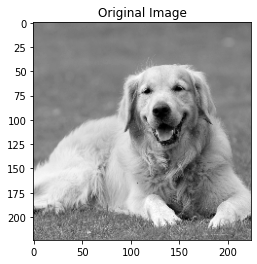

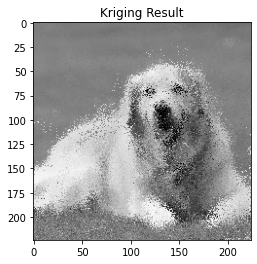

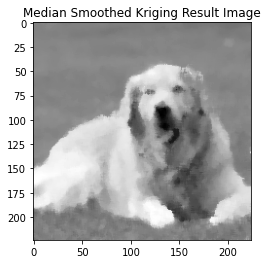

Simmulation of 2 image.


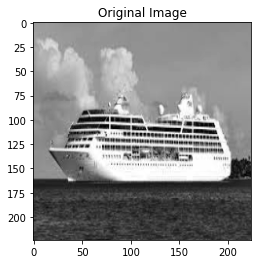

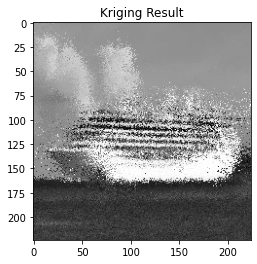

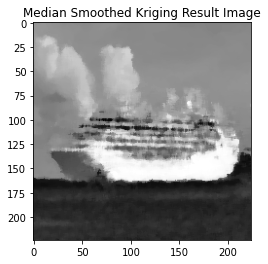

Simmulation of 3 image.


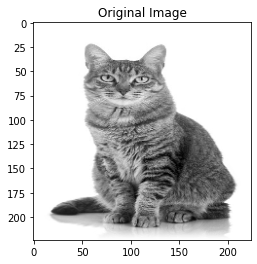

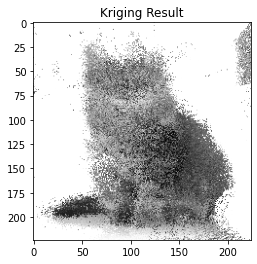

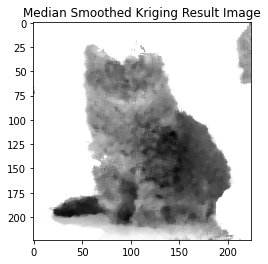

<Figure size 432x288 with 0 Axes>

In [ ]:

import cv2
for j in range(len(Images)):
  sample = Images[j]
  X_Cor = rn.sample(range(224),100)
  Y_Cor = rn.sample(range(224),100)
  test_image = np.zeros((224, 224))
  array = []
  for i in range(100):
    x, y, var = X_Cor[i],Y_Cor[i],sample[X_Cor[i]][Y_Cor[i]]
    array.append([x, y, var])
    test_image[x][y] = var
  array = np.array(array)  
  test_data = pd.DataFrame({'X':array[:, 0], 'Y':array[:, 1], 'var':array[:, 2]})
  print("Simmulation of "+str(j+1)+" image.")
  estimated_image = simmulator(test_image,test_data,sample)
  plt.imshow(sample, cmap='gray')
  plt.title('Original Image')
  plt.figure()
  plt.imshow(estimated_image, cmap='gray')
  plt.title('Kriging Result')
  plt.show()
  plt.figure()
  plt.imshow(cv2.medianBlur(estimated_image.astype(np.uint8), 5), cmap='gray')
  plt.title('Median Smoothed Kriging Result Image')
  plt.show()
  plt.figure()


